In [1]:
# Import all the dependencies and define some helpful functions
import numpy as np
import random
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import logging as log
from src.plotting import *
%load_ext autoreload
%autoreload 2

# set plotting style
%matplotlib inline
plt.style.reload_library()
plt.style.use('ucla_presentations')
mpl.rcParams['text.usetex'] = False

# configure logging
log.basicConfig(level= log.INFO, format = '')


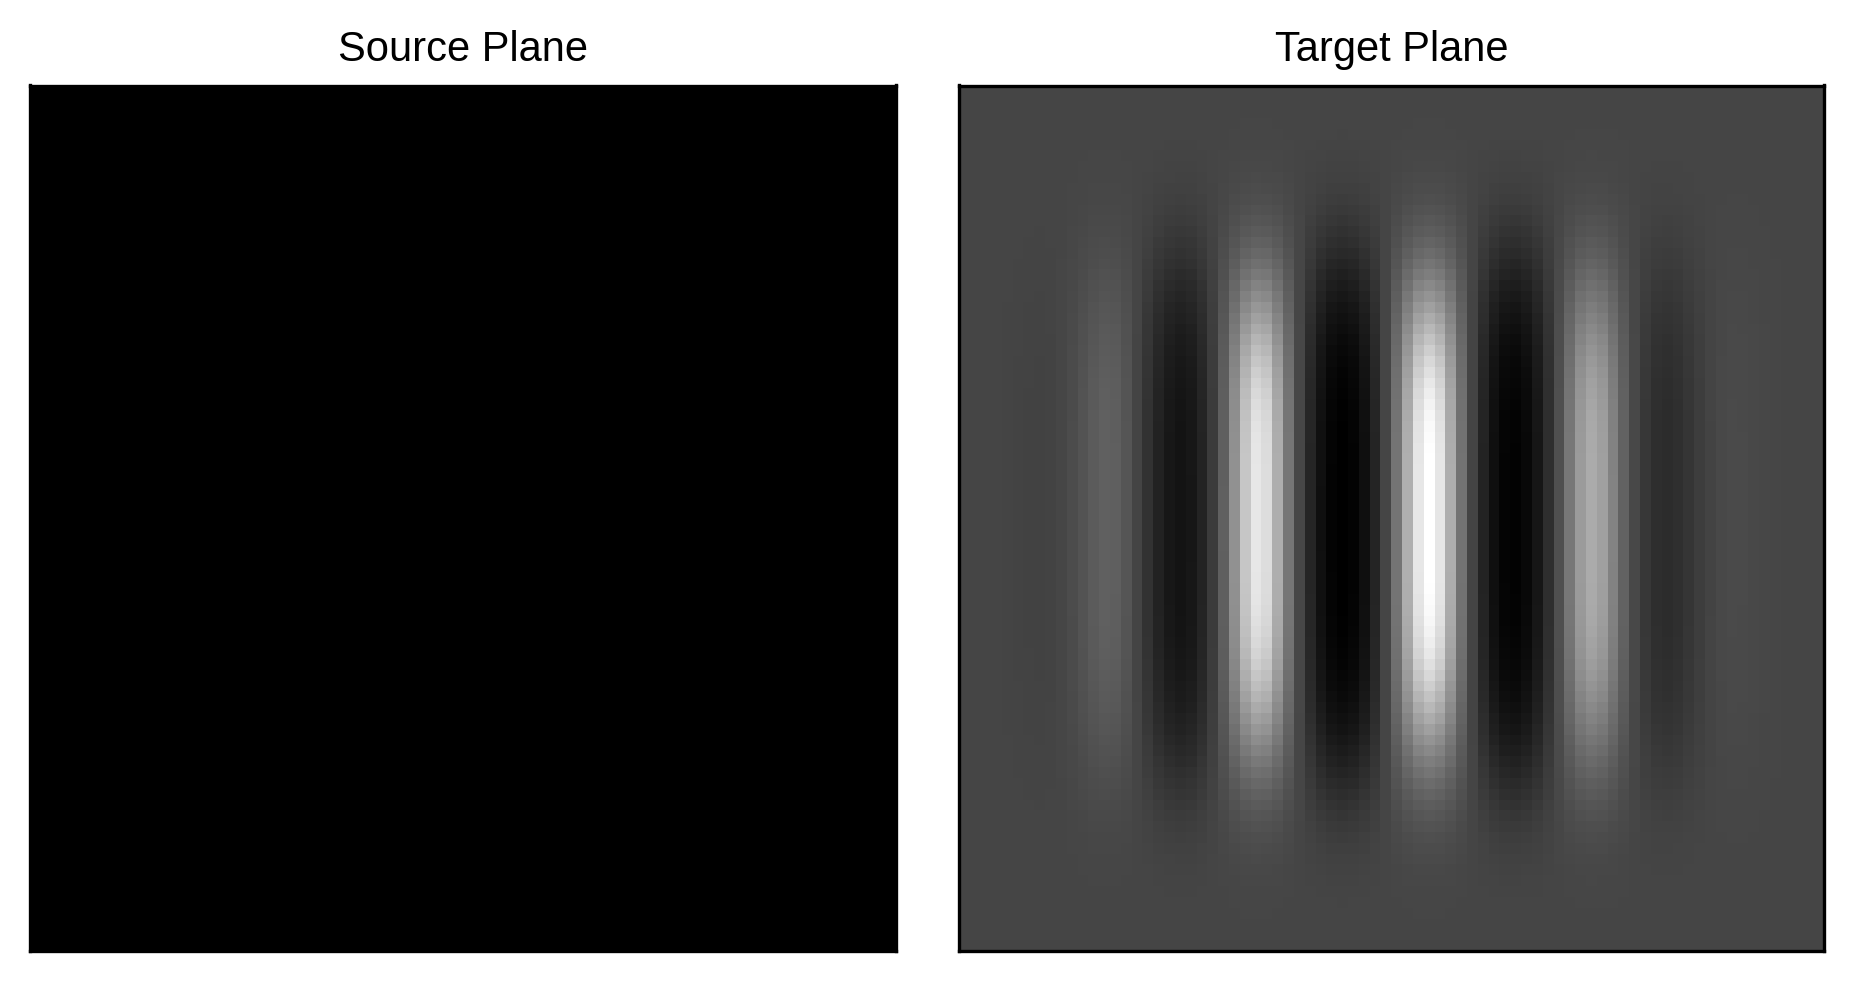

In [2]:
from scipy.io import loadmat

# Load in the benchmark images from binary Matlab files
data_dir = '/home/oods/Research/AE98-99/Analysis/voronoi/test_data/benchmark/'
tar_fname = data_dir + 'img_data.mat'
src_fname = data_dir + 'img_bg.mat'

tar_f = loadmat(tar_fname)
src_f = loadmat(src_fname)

tar_img = np.array(tar_f['img_data'], dtype=float)
src_img = np.array(src_f['img_bg'], dtype=float)

# Normalize the images
shape = tar_img.shape
N_pix = shape[0] * shape[1]
tar_img *= N_pix / np.sum(tar_img)
src_img *= N_pix / np.sum(src_img)

fig, (ax1, ax2) = plt.subplots(1,2)
Y, X = np.indices(tar_img.shape)

ax1.pcolormesh(X,Y, src_img, cmap='gray', vmax=tar_img.max())#, vmin = 0)
ax1.set_aspect('equal')
no_ticks(ax1)
ax1.set_title("Source Plane")

ax2.pcolormesh(X, Y, tar_img, cmap='gray', vmax=tar_img.max())#, vmin = 0)
ax2.set_aspect('equal')
no_ticks(ax2)
ax2.set_title("Target Plane")
plt.show()

In [3]:
from src import optimal_transport as ot

N = int(.8 * N_pix)
source = ot.initialize_sites(src_img, N)

Deploying N = 5120 sites on the source plane...
Performing Lloyd relaxation on the source plane...


Optimizing cell weights on the target plane (this will take a while)...
nfev = 0, f = -1309.2
nfev = 5, f = -1676.4
nfev = 10, f = -1973.6
nfev = 15, f = -2054.0
nfev = 20, f = -2267.4
nfev = 25, f = -2729.5
nfev = 30, f = -2989.5
nfev = 35, f = -3178.3
nfev = 40, f = -3288.6
nfev = 45, f = -3385.9
nfev = 50, f = -5315568.7
nfev = 55, f = -6248863.7
nfev = 60, f = -6248863.7
nfev = 65, f = -6248863.7
nfev = 70, f = -3369.6
nfev = 75, f = -6248863.7
nfev = 80, f = -6248863.7
nfev = 85, f = -6248863.7
Minimization succeeded after 46 iterations and 87 power diagrams
Calculating the centroids of the optimized cells...
Moving nearest sites to the corners of the image...
Interpolating the displacements...
Calculating the deflection potential...
Finished


CPU times: user 1min 2s, sys: 18 s, total: 1min 20s
Wall time: 16min 11s


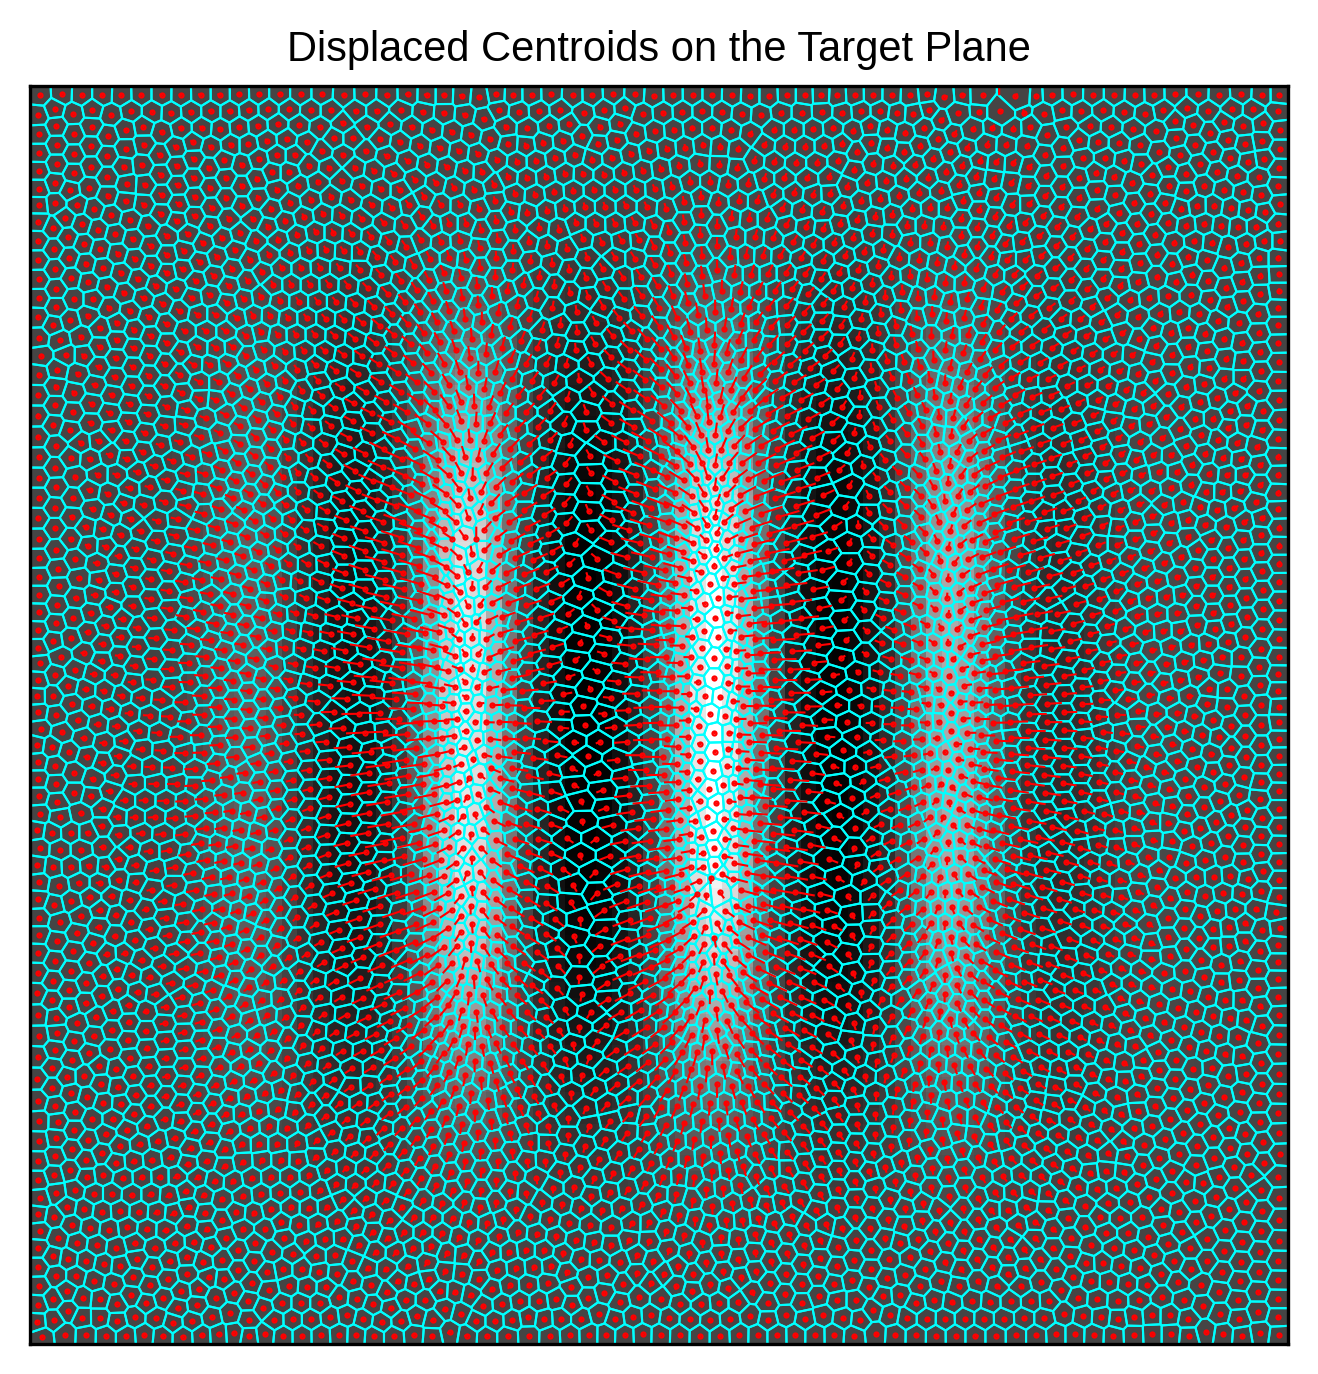

In [22]:
%%time
target, phi_c, a_x, a_y, result = ot.get_deflection_potential(tar_img, src_img, N, sites=source.sites)
ot.plot_displacements(target)

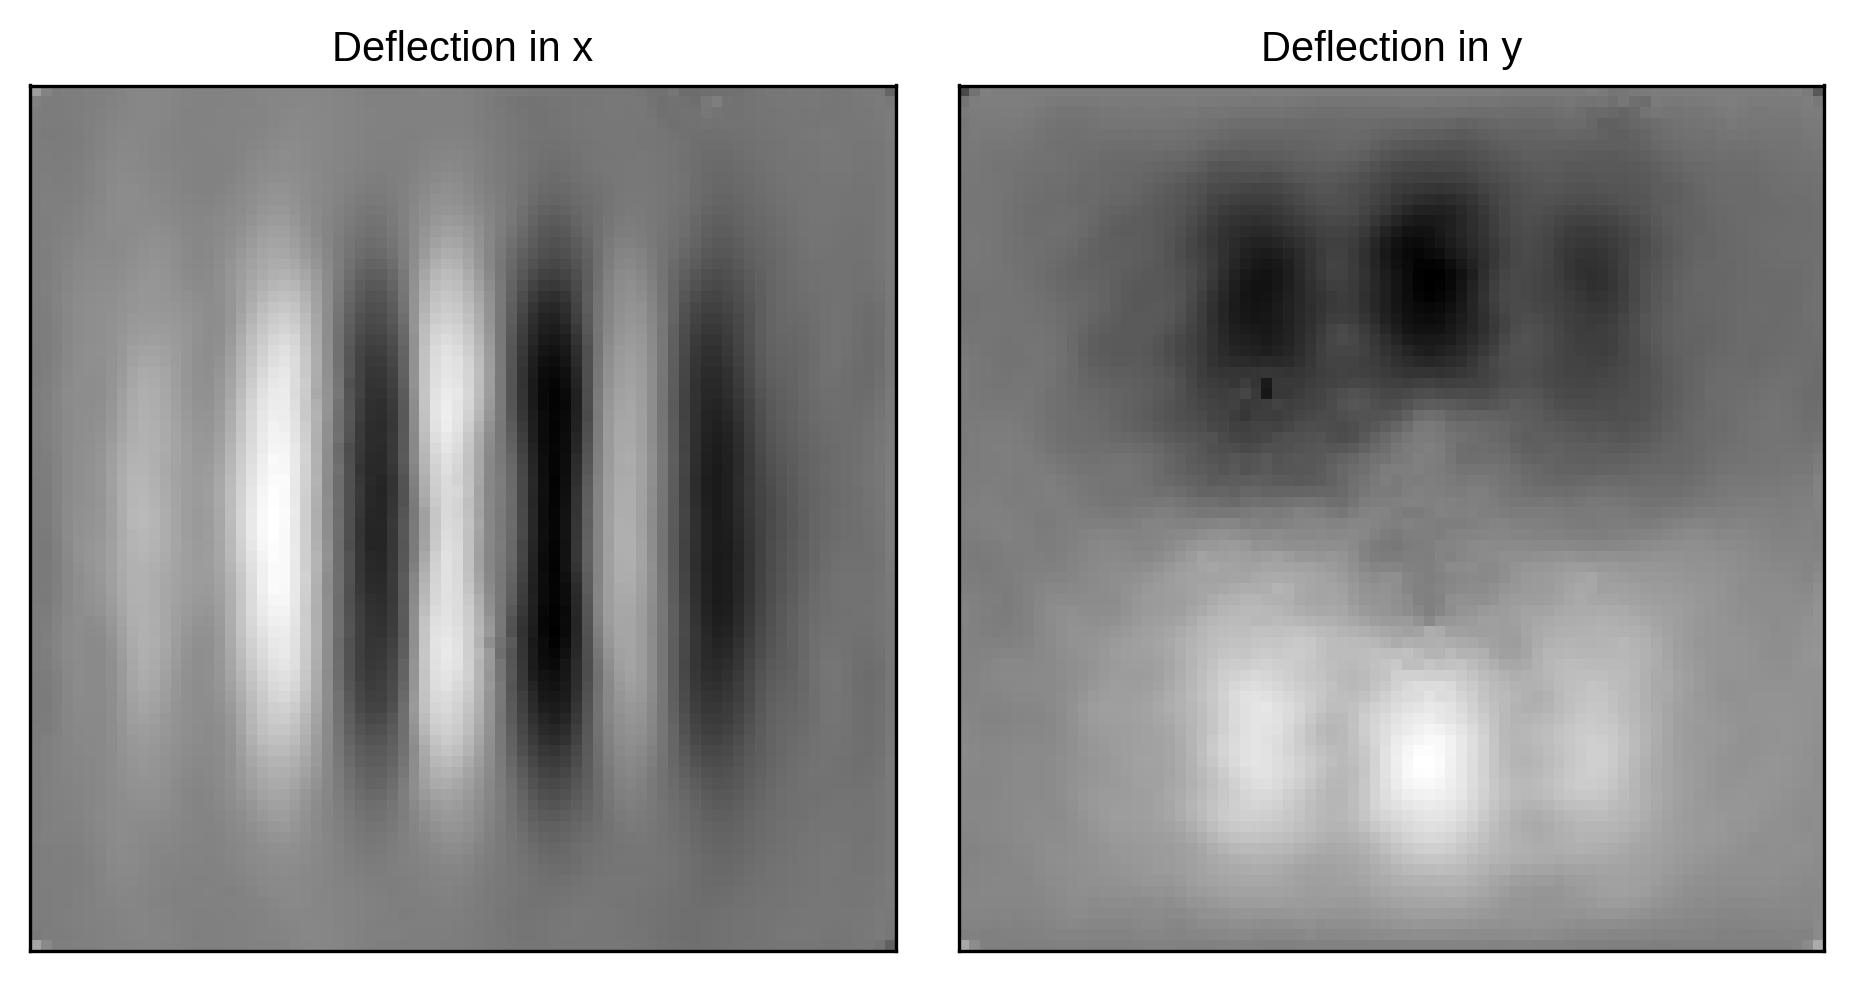

In [23]:
pad = 5

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.pcolormesh(X,Y, a_x, cmap='gray', vmax=a_x[pad:-pad, pad:-pad].max(), vmin = a_x[pad:-pad, pad:-pad].min())
ax1.set_aspect('equal')
no_ticks(ax1)
ax1.set_title("Deflection in x")

ax2.pcolormesh(X,Y, a_y, cmap='gray', vmax=a_y[pad:-pad, pad:-pad].max(), vmin = a_y[pad:-pad, pad:-pad].min())
ax2.set_aspect('equal')
no_ticks(ax2)
ax2.set_title("Deflection in y")
plt.show()

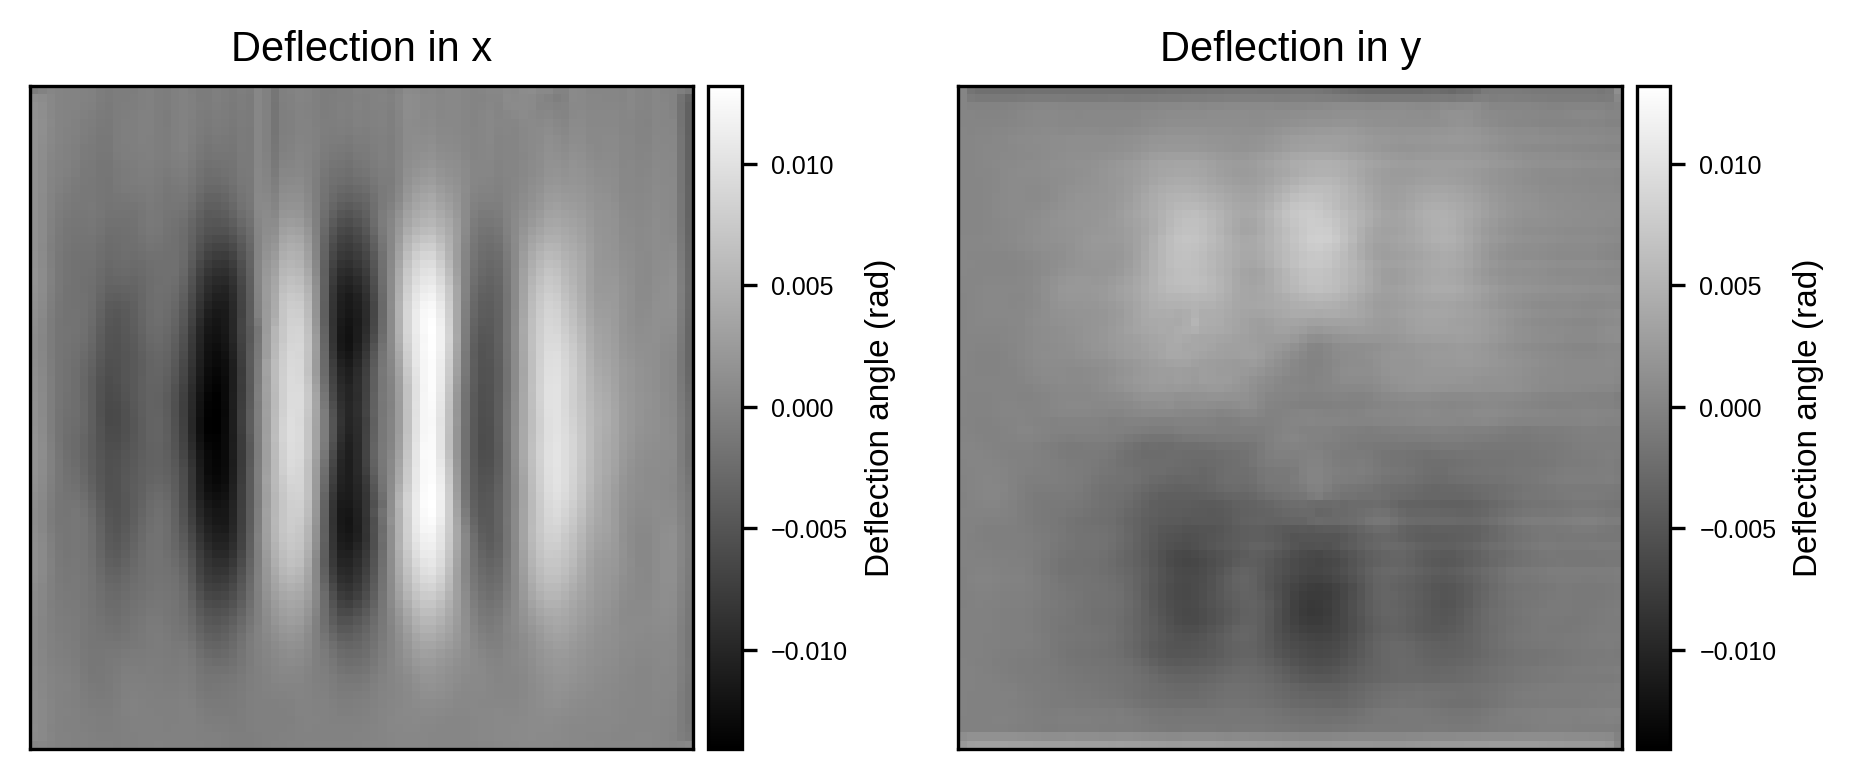

In [103]:
# Convert pixel displacement to deflection angle in radians

pix_size = 10   # micron
tar_dist = 1e4  # micron
M = 1 # magnification

phi = -1 * phi_c / tar_dist * pix_size**2 * M

angle_y, angle_x = np.gradient(phi)
angle_x *= -1
angle_y *= -1

fig, (ax1, ax2) = plt.subplots(1,2)

im1 = ax1.pcolormesh(X,Y, angle_x, cmap='gray', vmax=angle_x[pad:-pad, pad:-pad].max(), vmin = angle_x[pad:-pad, pad:-pad].min())
ax1.set_aspect('equal')
cbar1 = colorbar(im1)
cbar1.set_label('Deflection angle (rad)')
no_ticks(ax1)
ax1.set_title("Deflection in x")

im2 = ax2.pcolormesh(X,Y, angle_y, cmap='gray', vmax=angle_x[pad:-pad, pad:-pad].max(), vmin = angle_x[pad:-pad, pad:-pad].min())
ax2.set_aspect('equal')
cbar2 = colorbar(im2)
cbar2.set_label('Deflection angle (rad)')

no_ticks(ax2)
ax2.set_title("Deflection in y")
plt.show()

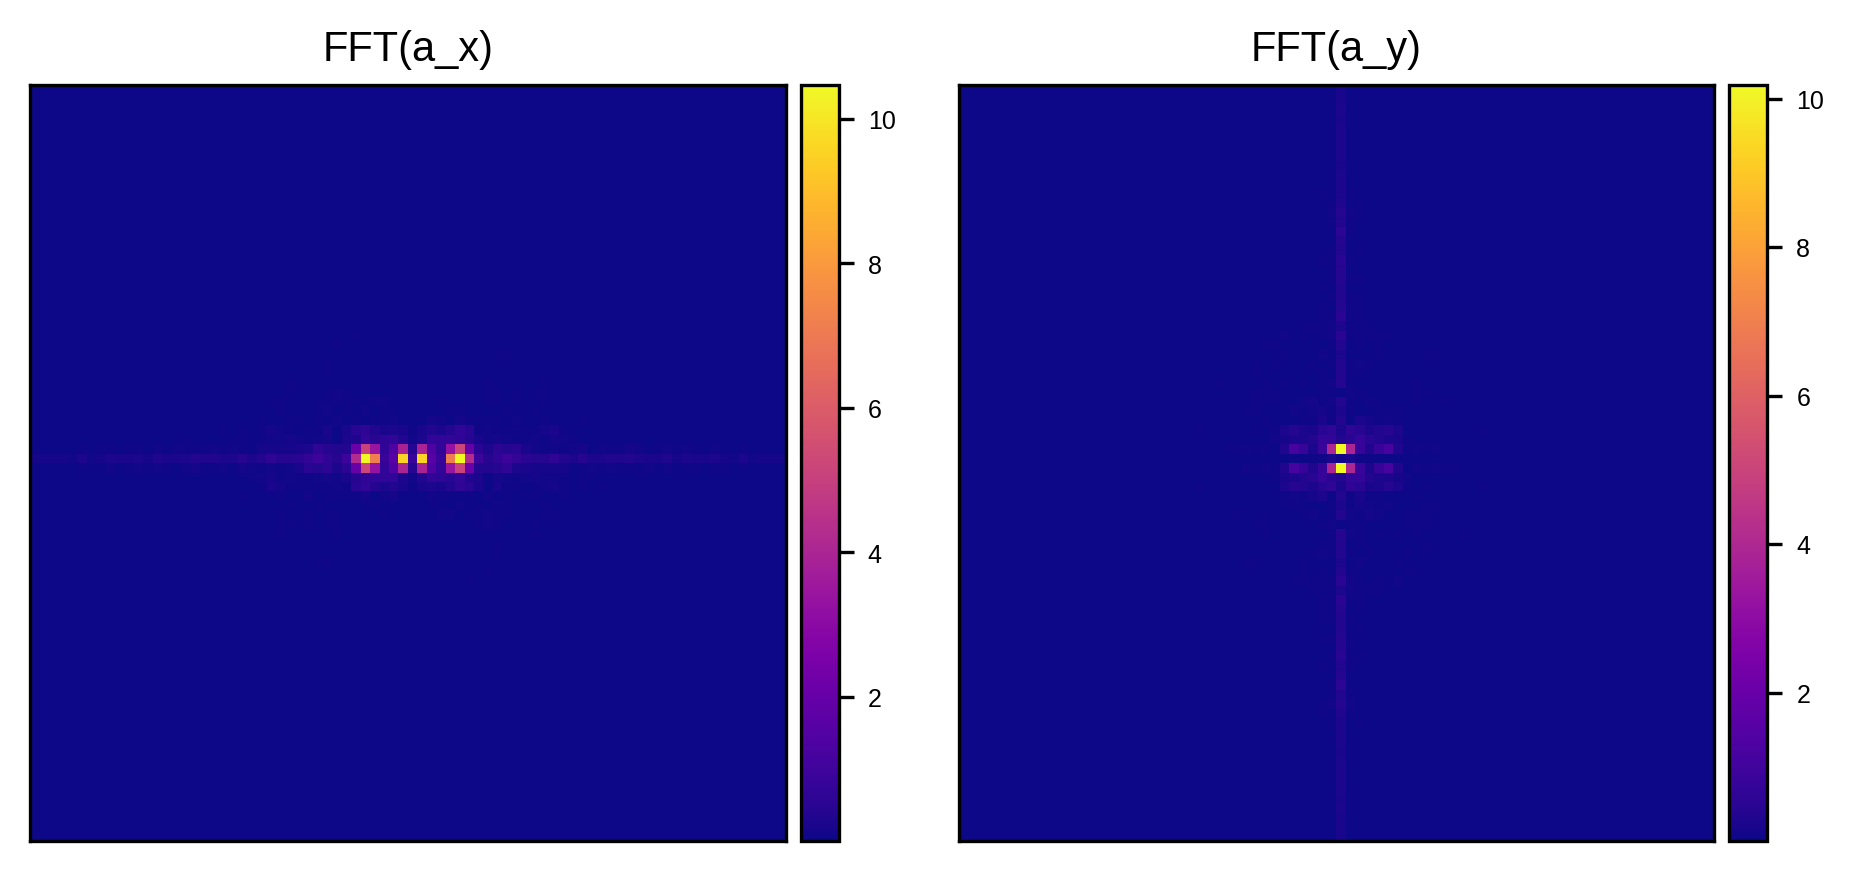

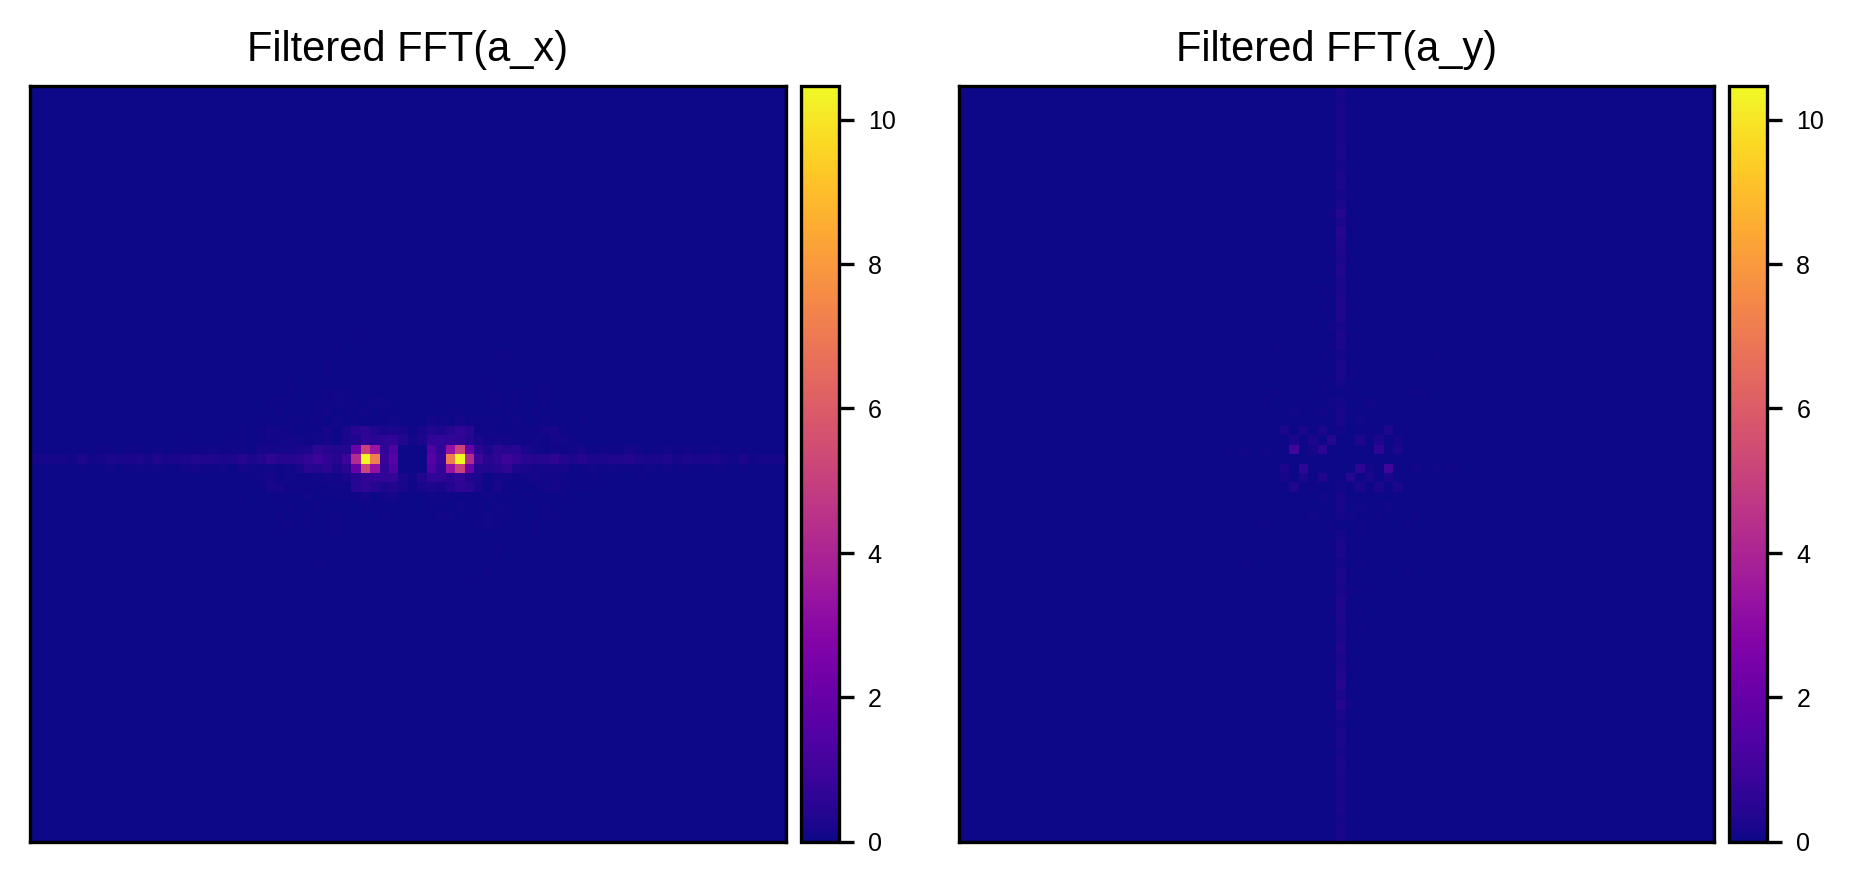

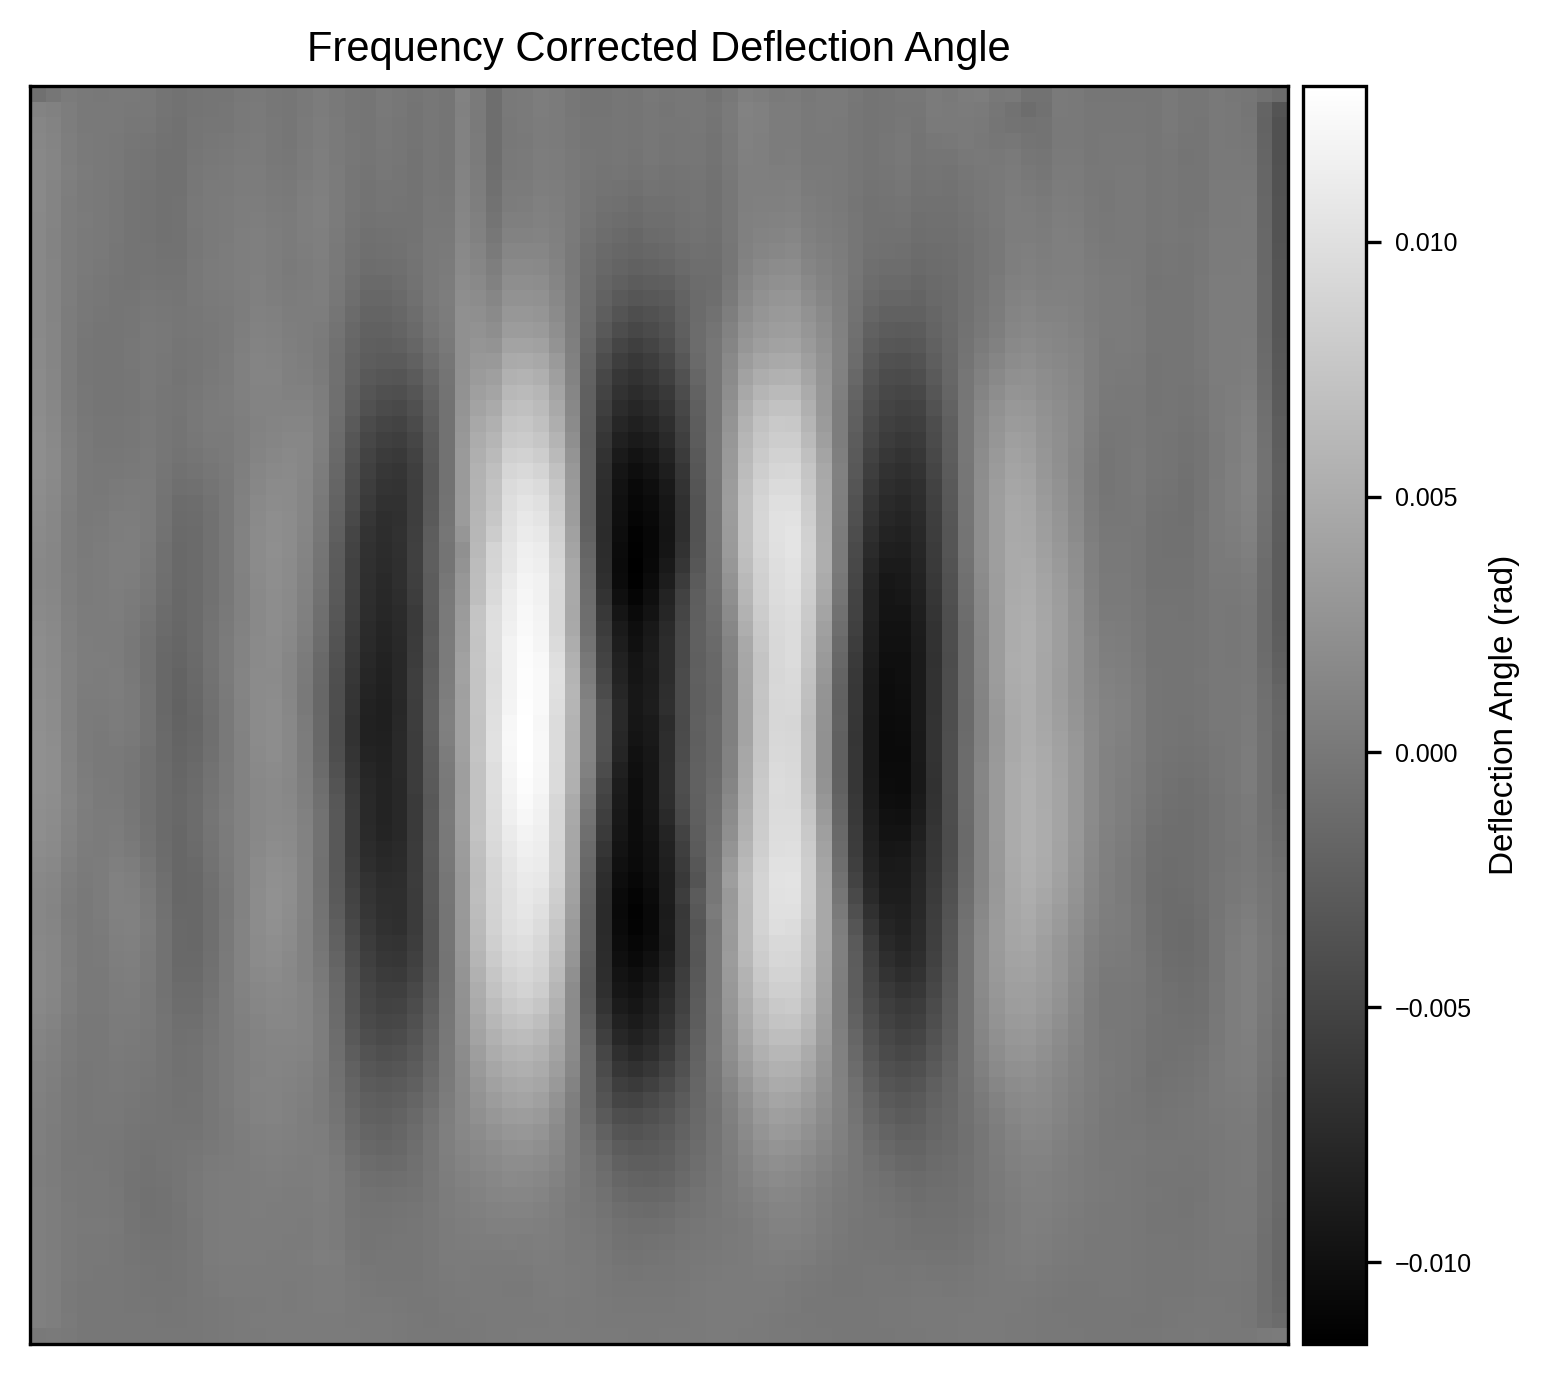

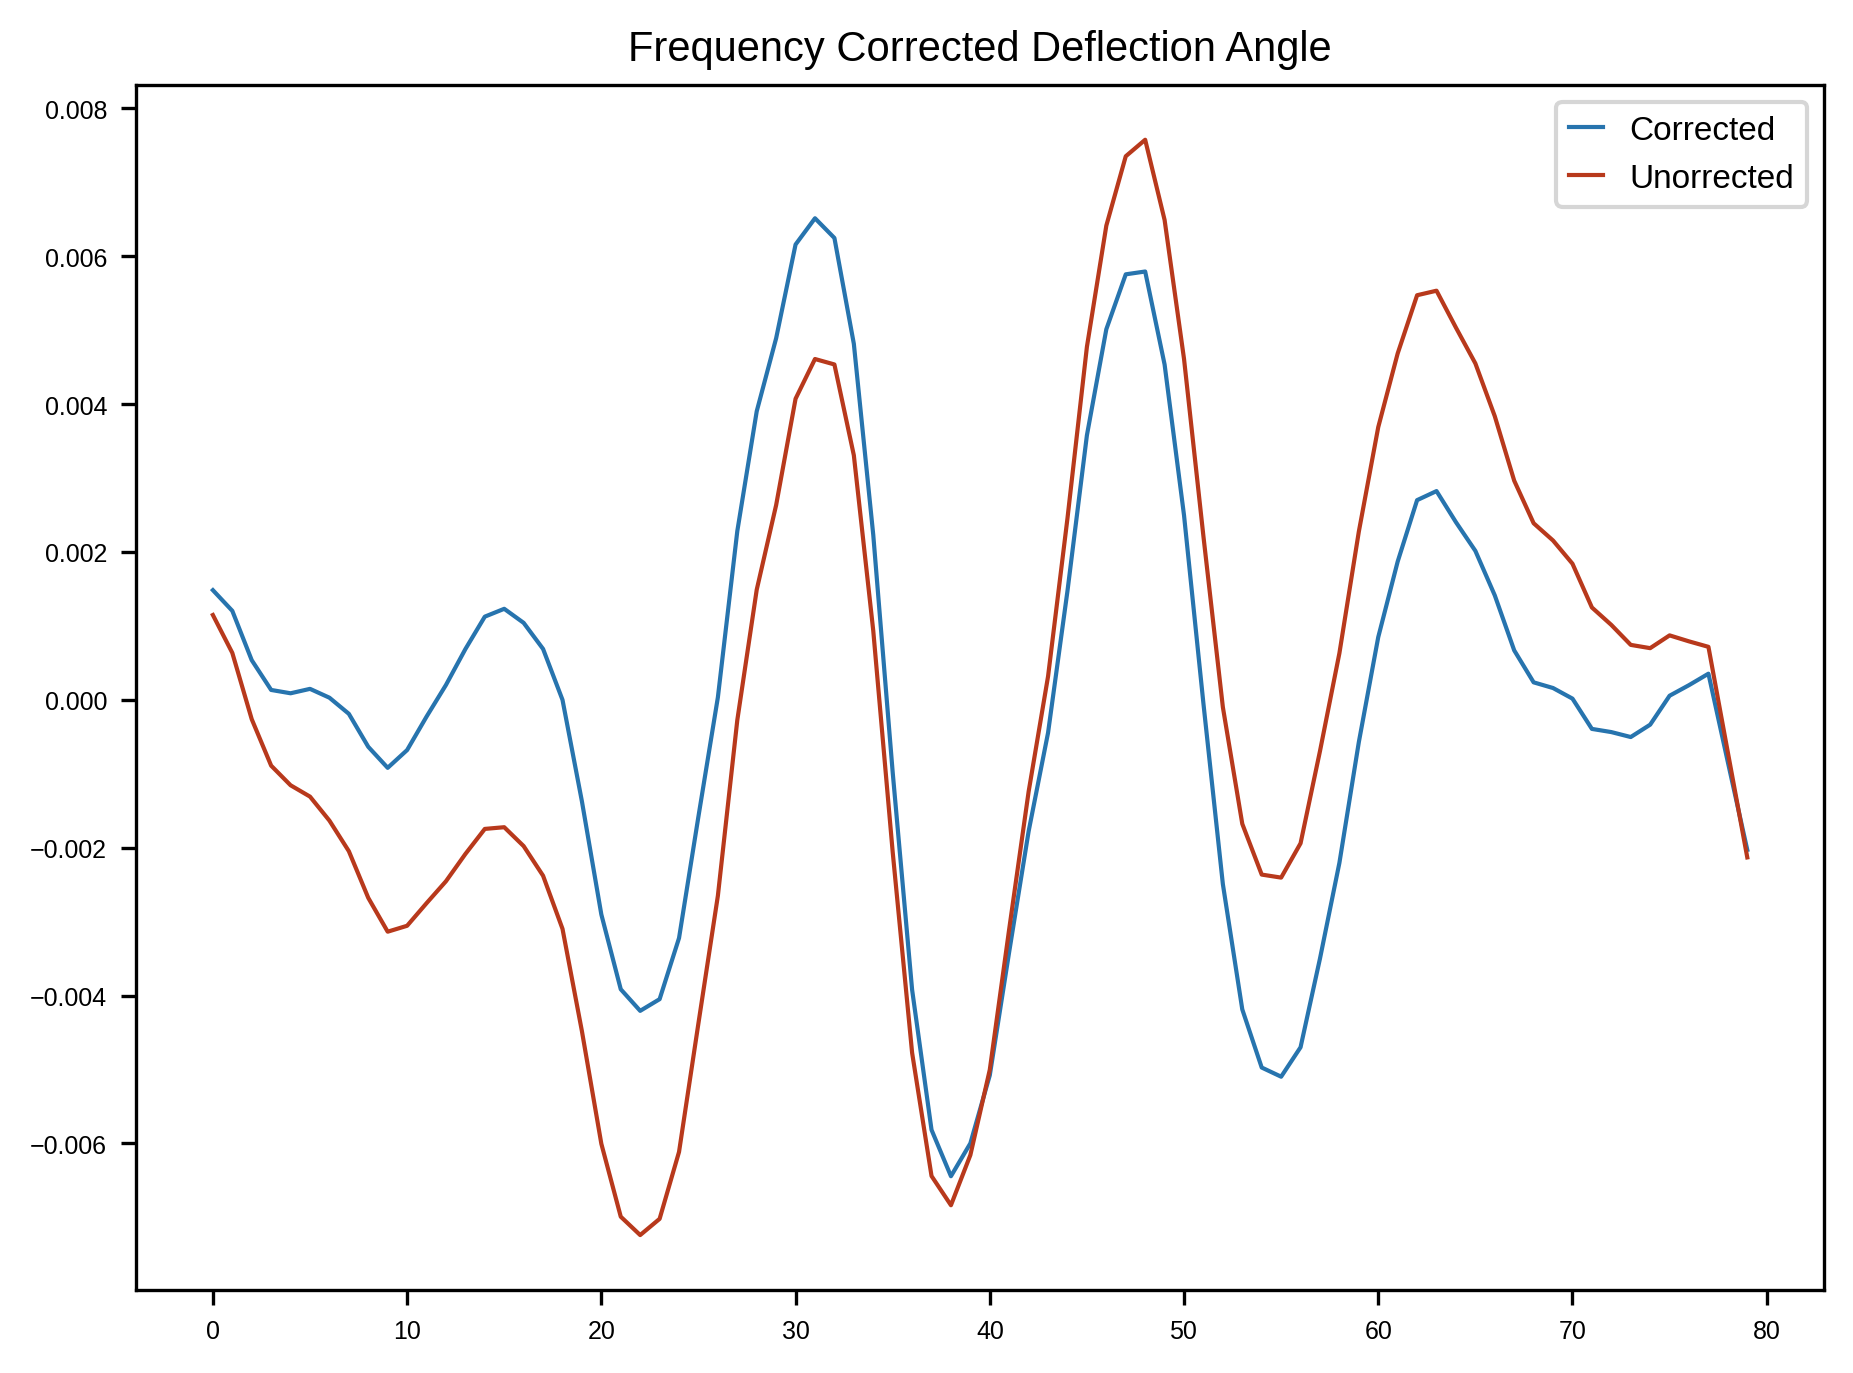

In [104]:
fftx = np.fft.fftshift(np.fft.fft2(angle_x))
ffty = np.fft.fftshift(np.fft.fft2(angle_y))

fig, (ax1, ax2) = plt.subplots(1,2)
im1 = ax1.pcolormesh(X,Y, np.abs(fftx), cmap='plasma')
ax1.set_aspect('equal')
cbar1 = colorbar(im1)
#cbar1.set_label('Deflection angle (rad)')
no_ticks(ax1)
ax1.set_title("FFT(a_x)")

#im2 = ax2.pcolormesh(X,Y, ffty.real, cmap='plasma', vmax=fftx[pad:-pad, pad:-pad].real.max(), vmin = fftx[pad:-pad, pad:-pad].real.min())
im2 = ax2.pcolormesh(X,Y, np.abs(ffty), cmap='plasma')
ax2.set_aspect('equal')
cbar2 = colorbar(im2)
#cbar2.set_label('Deflection angle (rad)')

no_ticks(ax2)
ax2.set_title("FFT(a_y)")
plt.show()

fftx[h//2 -1:h//2 +2, w//2 -1:w//2 +2] = 0
ffty[h//2 -1:h//2 +2, w//2 -1:w//2 +2] = 0
a_corrected = np.fft.ifft2(np.fft.ifftshift(fftx)).real

fig, (ax1, ax2) = plt.subplots(1,2)
im1 = ax1.pcolormesh(X,Y, np.abs(fftx), cmap='plasma')
ax1.set_aspect('equal')
cbar1 = colorbar(im1)
#cbar1.set_label('Deflection angle (rad)')
no_ticks(ax1)
ax1.set_title("Filtered FFT(a_x)")

im2 = ax2.pcolormesh(X,Y, ffty.real, cmap='plasma', vmax=np.abs(fftx).max(), vmin = np.abs(fftx).min())
ax2.set_aspect('equal')
cbar2 = colorbar(im2)
#cbar2.set_label('Deflection angle (rad)')

no_ticks(ax2)
ax2.set_title("Filtered FFT(a_y)")
plt.show()

fig, ax = plt.subplots()

im = ax.pcolormesh(X,Y, a_corrected, cmap='gray', vmax=a_corrected[pad:-pad, pad:-pad].max(), vmin = a_corrected[pad:-pad, pad:-pad].min())
ax.set_aspect('equal')
cbar = colorbar(im)
cbar.set_label('Deflection Angle (rad)')
no_ticks(ax)
ax.set_title("Frequency Corrected Deflection Angle")

plt.show()

fig, ax = plt.subplots()

ax.plot(np.mean(a_corrected, axis=0), label='Corrected')
ax.plot(np.mean(angle_x, axis=0), label='Unorrected')
ax.legend()
ax.set_title("Frequency Corrected Deflection Angle")

plt.show()

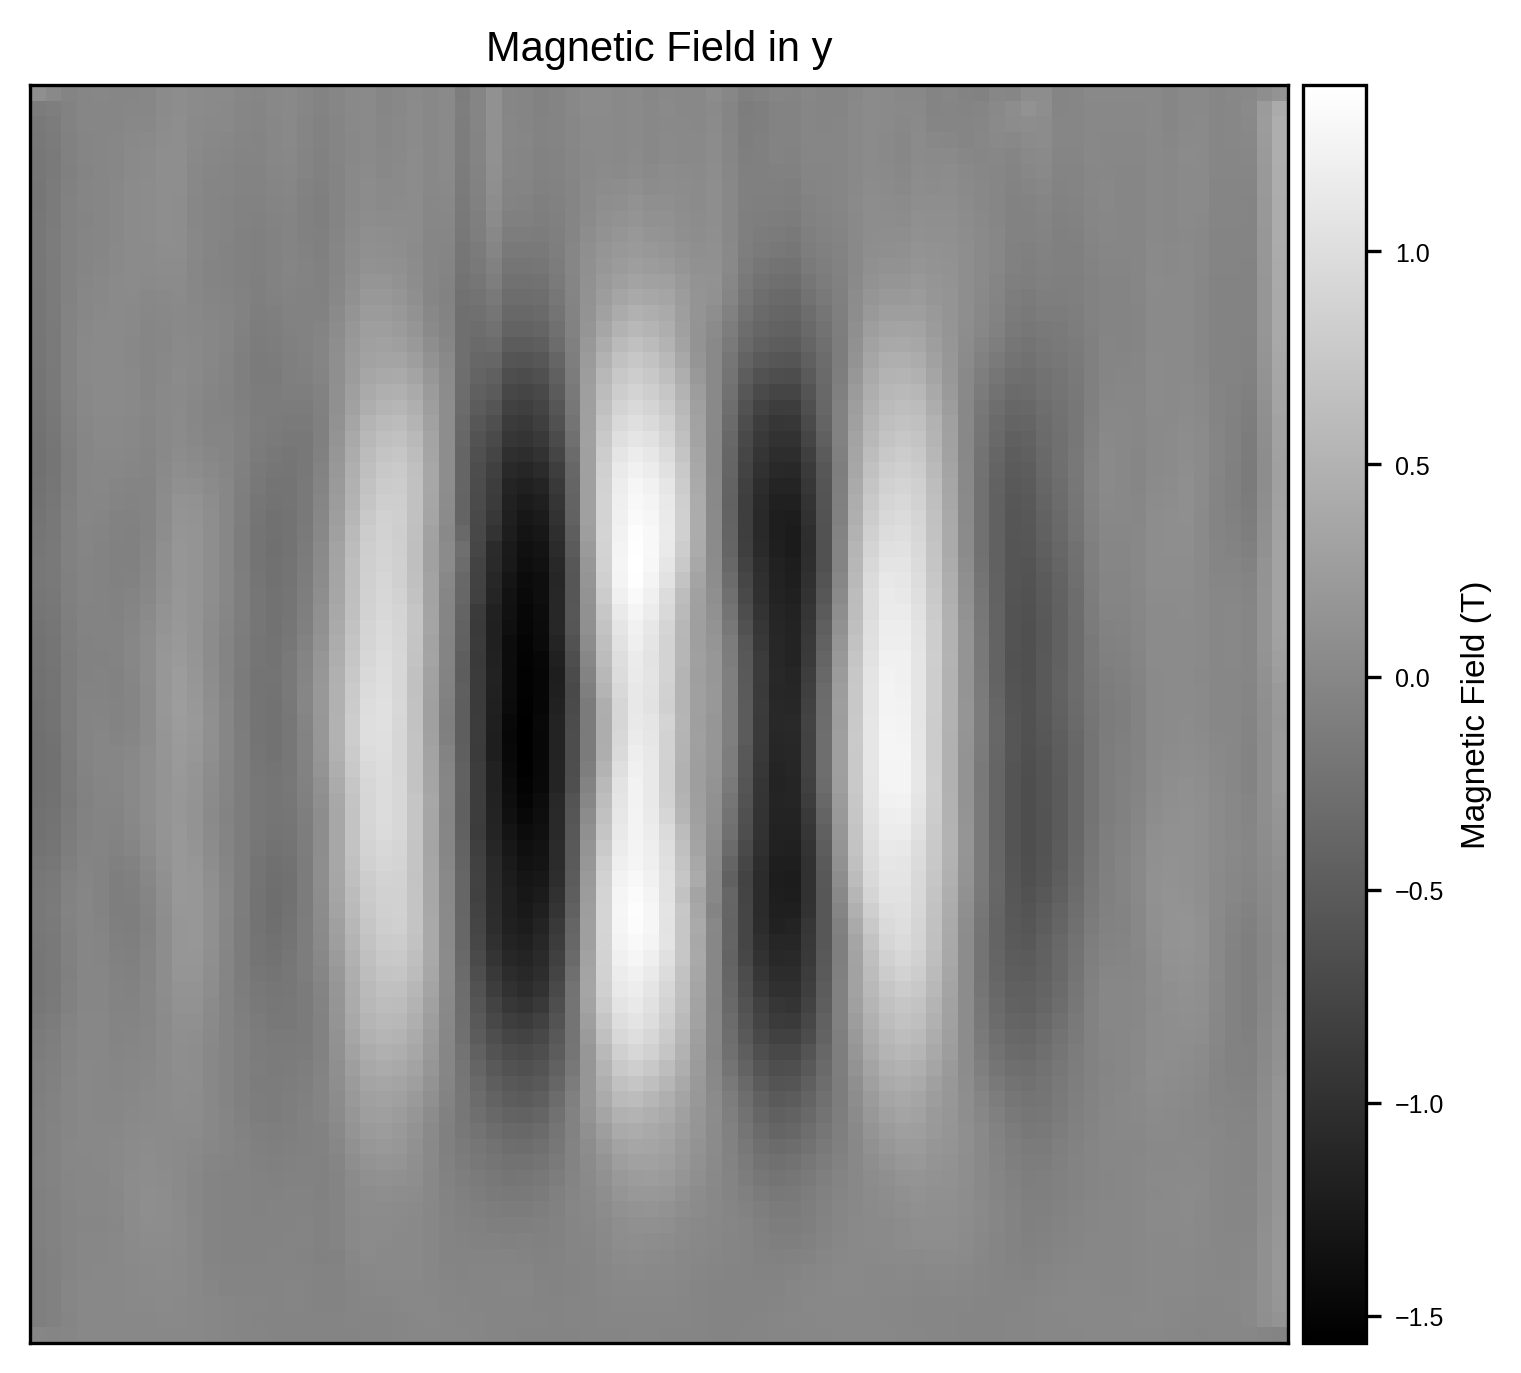

In [105]:
from astropy.constants import e, c, m_e
e = e.to(u.C)

W = 200 * u.um
E = 50.5 * u.MeV
B = (a_corrected * np.sqrt(2 * m_e * E) / (-1 * e * W)).to(u.T)

fig, ax = plt.subplots()

im = ax.pcolormesh(X,Y, B, cmap='gray')
ax.set_aspect('equal')
cbar = colorbar(im)
cbar.set_label('Magnetic Field (T)')
no_ticks(ax)
ax.set_title("Magnetic Field in y")

plt.show()